In [20]:
!pip install --quiet langchain langchain-google-genai grandalf
!pip install -qU langchain-deepseek
!pip install --quiet langchain_community

In [59]:
from langchain.prompts import PromptTemplate, ChatPromptTemplate
from langchain.chains import LLMChain
from langchain.globals import set_verbose
set_verbose(True)
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain_core.runnables import RunnablePassthrough

import os
from google.colab import drive
import google.generativeai as genai

from langchain_deepseek import ChatDeepSeek
from langchain_google_genai import ChatGoogleGenerativeAI
import json
import re
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


String, Sorting, Matrix

In [23]:
# Monta o diretório do drive para acessar os arquivos
drive.mount("/content/drive", force_remount=True)

# Lê a chave de API do arquivo JSON
with open('/content/drive/MyDrive/DeepSeekAPI/key_api_llm.json') as config_file:
    config = json.load(config_file)
    api_key = config['gemini_flash']

os.environ['GOOGLE_API_KEY'] = f"{api_key}"
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    api_key=os.environ["GOOGLE_API_KEY"]
  )

Mounted at /content/drive


#Prompts

In [24]:
template_requisicao = '''
You are an expert in solving computational algorithm problems using the Python programming language.
Consider that you are going to solve a problem from the LeetCode platform that involves computational algorithms.

Follow these guidelines:
  Try to solve the problem in the best possible way.
  Think step by step about how to approach this problem.
  Consider that you'll get the inputs and you need to return the answer according to the problem!!!!
  Consider that your function needs to be inside the class "Solution(object)"
ATTENTION: The final answer with the code to solve the problem must be separated from the rest and needs to be at text end.

See an example of solving a problem:
<EXAMPLE>

<PROBLEM>
Given a non-empty array of integers nums, every element appears twice except for one. Find that single one.

You must implement a solution with a linear runtime complexity and use only constant extra space.

Example 1:

Input: nums = [2,2,1]

Output: 1

Example 2:

Input: nums = [4,1,2,1,2]

Output: 4

Example 3:

Input: nums = [1]

Output: 1



Constraints:

1 <= nums.length <= 3 * 104
-3 * 104 <= nums[i] <= 3 * 104
Each element in the array appears twice except for one element which appears only once.

</PROBLEM>


<ANSWER>
The problem asks to find the single unique element in an array where all other elements appear twice.  The constraints specify linear time and constant space complexity. This strongly suggests using bit manipulation, specifically the XOR operator.

The XOR operator has the following properties relevant to this problem:

* `x ^ x == 0`  (XORing a number with itself results in 0)
* `x ^ 0 == x` (XORing a number with 0 results in the number itself)
* `x ^ y ^ x == y` (XOR is associative and commutative)

Therefore, if we XOR all the numbers in the array, the numbers that appear twice will cancel each other out (because `x ^ x == 0`), leaving only the unique number.

Let's outline the algorithm:

1. Initialize a variable `result` to 0.
2. Iterate through the input array `nums`.
3. For each number `num` in `nums`, perform `result ^= num`.
4. After the loop, `result` will contain the unique number.
5. Return `result`.


This approach guarantees linear time complexity (O(n) where n is the length of `nums`) because we iterate through the array once.  It also uses constant extra space (O(1)) because we only use a single integer variable `result`.

Error Handling:  The problem statement guarantees a non-empty array and that only one element appears once.  However, robust code should handle edge cases, although it's not strictly required here.  We'll include a check for an empty input array for completeness.


```python
class Solution(object):
    def singleNumber(self, nums):
        """
        :type nums: List[int]
        :rtype: int
        """
        if not nums:  # Handle empty input
            return None  # or raise an exception depending on requirements

        result = 0
        for num in nums:
            result ^= num
        return result

```

**Final Answer with Code:**

```python
class Solution(object):
    def singleNumber(self, nums):
        """
        :type nums: List[int]
        :rtype: int
        """
        if not nums:  # Handle empty input
            return None  # or raise an exception depending on requirements

        result = 0
        for num in nums:
            result ^= num
        return result
```
</ANSWER>
</EXAMPLE>

Now it's tour turn! Solve the following problem:
{problem}
'''

In [25]:
template_erro = '''
You are an expert in solving computational algorithm problems using the Python programming language.
Consider that you are going to solve a problem from the LeetCode platform that involves computational algorithms.

Follow these guidelines:
  Try to solve the problem in the best possible way.
  Think step by step about how to approach this problem.
  Consider that you'll get the inputs and you need to return the answer according to the problem!!!!
  Consider that your function needs to be inside the class "Solution(object)"

Solve the following problem:
{problem}

You have this initial code to solve the problem but it didn't pass in all test cases for this problem.

{code}

This code had the following error:

{error}

Try to fix it so that the code passes through all test cases.

ATTENTION: The final answer with the code to solve the problem must be separated from the rest in ```python``` format.

'''

In [26]:
prompt_requisicao = PromptTemplate(
  input_variables = ['problem'],
  template = template_requisicao
)

In [27]:
prompt_erro = PromptTemplate(
  input_variables = ['problem', 'code', 'error'],
  template = template_erro
)

#Functions

In [28]:
def get_code(problema: str, max_iterations: int):
  all_answers = []
  all_codes = []

  # LLM chain in LangChain
  initial_chain = RunnablePassthrough() | prompt_requisicao | llm | StrOutputParser()
  answer = initial_chain.invoke({"problem": problema})


  all_answers.append(answer)
  code_answer = encontrar_ultimo_codigo_python(answer)
  all_codes.append(code_answer)
  print(answer)
  print("\n\n\n-------------------------------------------------------------------------------------\n\n\n")


  for i in range(max_iterations):
    erro = input()
    if erro == 'passou':
      break

    error_chain = RunnablePassthrough() | prompt_erro | llm | StrOutputParser()
    answer = error_chain.invoke({"problem": problema, "code": code_answer, "error": erro})

    all_answers.append(answer)
    code_answer = encontrar_ultimo_codigo_python(answer)
    all_codes.append(code_answer)
    print(answer)
    print("\n\n\n-------------------------------------------------------------------------------------\n\n\n")

In [29]:
def encontrar_ultimo_codigo_python(texto):
    padrao = r"```python(.*?)```"
    matches = re.findall(padrao, texto, re.DOTALL)  # Encontra todos os trechos

    if matches:
        return matches[-1].strip()  # Retorna o último trecho encontrado
    return None  # Retorna None se não encontrar nenhum trecho

#Execução

In [56]:
problema = '''
You are given an 8 x 8 matrix representing a chessboard. There is exactly one white rook represented by 'R', some number of white bishops 'B', and some number of black pawns 'p'. Empty squares are represented by '.'.

A rook can move any number of squares horizontally or vertically (up, down, left, right) until it reaches another piece or the edge of the board. A rook is attacking a pawn if it can move to the pawn's square in one move.

Note: A rook cannot move through other pieces, such as bishops or pawns. This means a rook cannot attack a pawn if there is another piece blocking the path.

Return the number of pawns the white rook is attacking.



Example 1:


Input: board = [[".",".",".",".",".",".",".","."],[".",".",".","p",".",".",".","."],[".",".",".","R",".",".",".","p"],[".",".",".",".",".",".",".","."],[".",".",".",".",".",".",".","."],[".",".",".","p",".",".",".","."],[".",".",".",".",".",".",".","."],[".",".",".",".",".",".",".","."]]

Output: 3

Explanation:

In this example, the rook is attacking all the pawns.

Example 2:


Input: board = [[".",".",".",".",".",".","."],[".","p","p","p","p","p",".","."],[".","p","p","B","p","p",".","."],[".","p","B","R","B","p",".","."],[".","p","p","B","p","p",".","."],[".","p","p","p","p","p",".","."],[".",".",".",".",".",".",".","."],[".",".",".",".",".",".",".","."]]

Output: 0

Explanation:

The bishops are blocking the rook from attacking any of the pawns.

Example 3:


Input: board = [[".",".",".",".",".",".",".","."],[".",".",".","p",".",".",".","."],[".",".",".","p",".",".",".","."],["p","p",".","R",".","p","B","."],[".",".",".",".",".",".",".","."],[".",".",".","B",".",".",".","."],[".",".",".","p",".",".",".","."],[".",".",".",".",".",".",".","."]]

Output: 3

Explanation:

The rook is attacking the pawns at positions b5, d6, and f5.
'''

In [57]:
get_code(problema, 3)

```python
class Solution(object):
    def countAttackingPawns(self, board):
        """
        :type board: List[List[str]]
        :rtype: int
        """

        rows = len(board)
        cols = len(board[0]) if rows > 0 else 0

        # Find the rook's position
        rook_row, rook_col = -1, -1
        for r in range(rows):
            for c in range(cols):
                if board[r][c] == 'R':
                    rook_row, rook_col = r, c
                    break
            if rook_row != -1:
                break

        if rook_row == -1:  # Handle case where no rook is found.
            return 0

        count = 0
        # Check horizontally
        for c in range(rook_col + 1, cols):
            if board[rook_row][c] == 'p':
                count += 1
                break
            elif board[rook_row][c] != '.':
                break
        for c in range(rook_col - 1, -1, -1):
            if board[rook_row][c] == 'p':
                count += 1
                

# Resultados - Visualização Gráfica

In [90]:
df = pd.read_excel("/content/drive/MyDrive/DeepSeekAPI/TAES - planilha.xlsx")

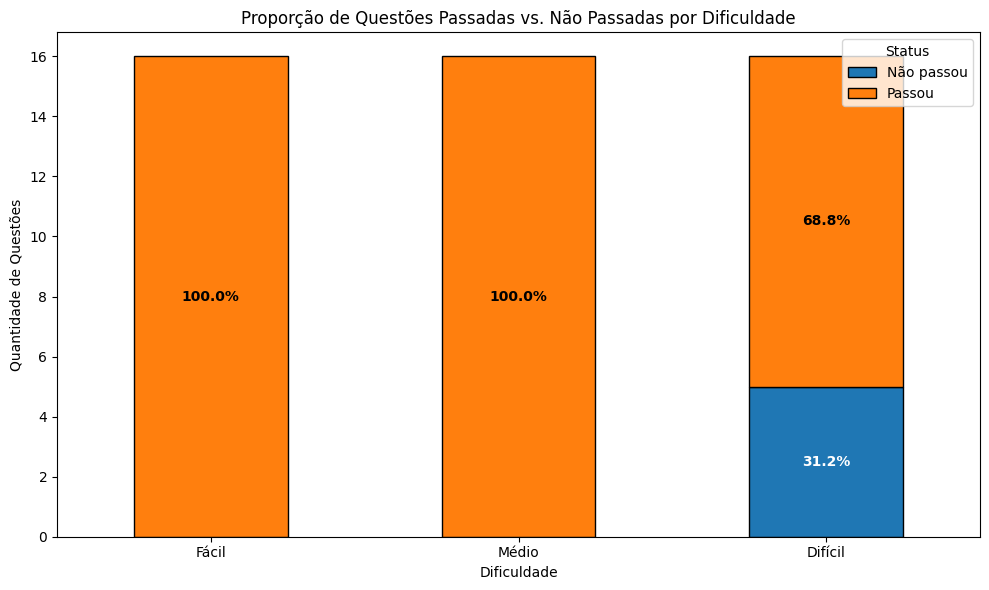

In [91]:
df['Status'] = df['Iteração'].apply(lambda x: 'Passou' if x not in ["WA", "TLE"] else 'Não passou')

contagem = df.groupby(['Dificuldade', 'Status']).size().unstack(fill_value=0)

dificuldade_order = ['Fácil', 'Médio', 'Difícil']
contagem = contagem.loc[dificuldade_order]

ax = contagem.plot(kind='bar', stacked=True, figsize=(10, 6),
                   color=['#1f77b4', '#ff7f0e'],
                   edgecolor='black')

plt.title('Proporção de Questões Passadas vs. Não Passadas por Dificuldade')
plt.xlabel('Dificuldade')
plt.ylabel('Quantidade de Questões')
plt.xticks(rotation=0)
plt.legend(title='Status')


total_por_dificuldade = contagem.sum(axis=1)
for i, dificuldade in enumerate(contagem.index):
    passou = contagem.loc[dificuldade, 'Passou']
    nao_passou = contagem.loc[dificuldade, 'Não passou']
    total = total_por_dificuldade[dificuldade]


    if nao_passou > 0:
        plt.text(i, nao_passou/2, f"{nao_passou/total*100:.1f}%",
                 ha='center', va='center', color='white', fontweight='bold')


    if passou > 0:
        plt.text(i, nao_passou + passou/2, f"{passou/total*100:.1f}%",
                 ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

<ipython-input-99-f7f30cbea449>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(['Dificuldade', 'Iteração']).size().unstack(fill_value=0)


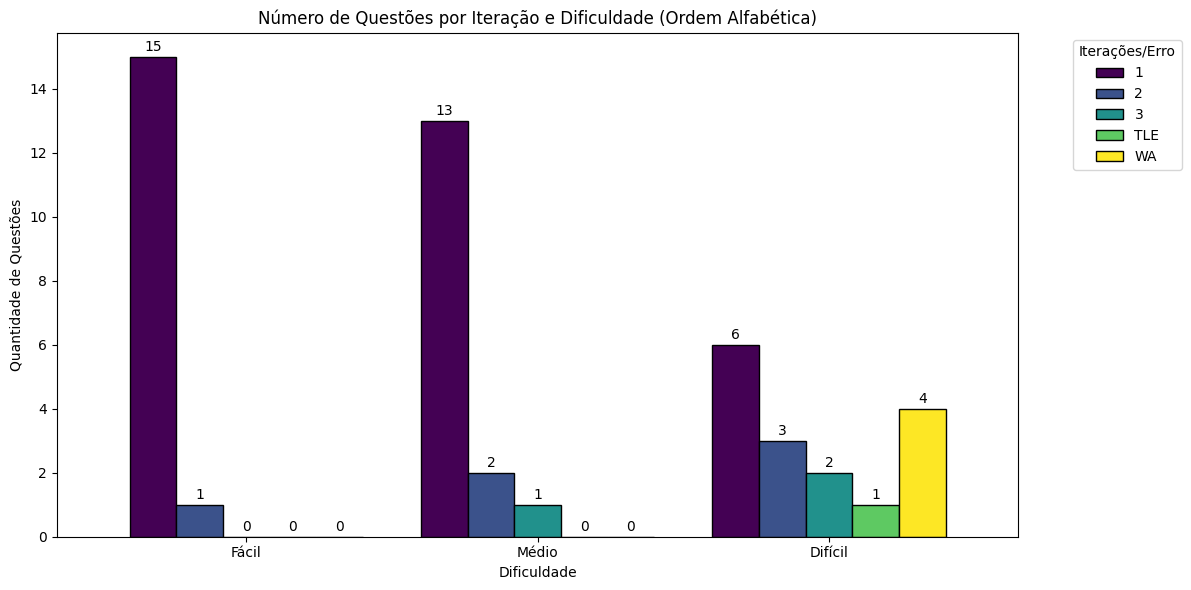

In [99]:
df['Iteração'] = df['Iteração'].astype(str)

df['Dificuldade'] = pd.Categorical(df['Dificuldade'],
                                 categories=['Fácil', 'Médio', 'Difícil'],
                                 ordered=True)
result = df.groupby(['Dificuldade', 'Iteração']).size().unstack(fill_value=0)

ax = result.plot(kind='bar', figsize=(12, 6), width=0.8,
                 edgecolor='black', colormap='viridis')

plt.title('Número de Questões por Iteração e Dificuldade (Ordem Alfabética)')
plt.xlabel('Dificuldade')
plt.ylabel('Quantidade de Questões')
plt.xticks(rotation=0)

for container in ax.containers:
    ax.bar_label(container, label_type='edge', padding=2)

plt.legend(title='Iterações/Erro', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()